# Some *tests* of the inner functionality of the whole dqn package

## (a) Testing unity ml-agents env wrapper

In [ ]:
import os
import sys
import numpy as np

from navigation.envs import mlagents

In [ ]:
# definitions for full paths to executables
EXEC_BANANA_PATH = os.path.join( os.getcwd(), 'executables/Banana_Linux/Banana.x86_64' )
EXEC_BANANA_NOVIS_PATH = os.path.join( os.getcwd(), 'executables/Banana_Linux_NoVis/Banana.x86_64' )

In [ ]:
# initialize the environment
_env = mlagents.createDiscreteActionsEnv( EXEC_BANANA_PATH )
## _env = mlagents.createDiscreteActionsEnv( EXEC_BANANA_NOVIS_PATH )

In [ ]:
print( 'numActions: ', _env.numActions )
print( 'obsShape: ', _env.obsShape )

In [ ]:
_state = _env.reset( training = False )
print( '_state.shape: ', _state.shape )
print( '_state:' )
_raysState = _state[:-2].reshape( 7, -1 )
print( '_raysState: ' )
print( _raysState )

def process( state ) :
    return state[:-2].reshape( 7, -1 )

In [ ]:
_raysState[:,[0,2,4]]

In [ ]:
_state = _env.reset( training = False )

while True :
    
    _action = np.random.randint( _env.numActions )
    _snext, _reward, _done, _ = _env.step( 2 )
    
    print( '#######################' )
    print( '_snext: ' )
    print( process( _snext ) )
    print( '_reward: ', _reward )
    print( '_done: ', _done )
    
    if _done :
        break

_env.close()

## Testing the sumtree data structure

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from navigation.dqn.utils import sumtree

In [ ]:
smtree = sumtree.SumTree(8)

smtree.add( 'a', 3 )
smtree.add( 'b', 10 )
smtree.add( 'c', 12 )
smtree.add( 'd', 4 )
smtree.add( 'e', 1 )
smtree.add( 'f', 2 )
smtree.add( 'g', 8 )
smtree.add( 'h', 2 )

In [ ]:
smtree.getNode(41.99999)

In [ ]:
print( 'arr-tree: ', smtree._tree )
print( 'data: ', smtree._data )

In [ ]:
smtree = sumtree.SumTree(8)

smtree.add( 'a', 3 )
smtree.add( 'b', 10 )
smtree.add( 'c', 12 )
smtree.add( 'd', 4 )
smtree.add( 'e', 1 )
smtree.add( 'f', 2 )
smtree.add( 'g', 8 )

smtree.total()

In [ ]:
smtree._tree

In [ ]:
smtree.getNode(39.87)

### testing sampling method

In [ ]:
_val = 42. * np.random.random()
_indx, _nodeval, _data = smtree.getNode( _val )
print( 'sampled (%s), with nodeval=%.2f and indx=%i, for value=%.2f' % ( _data, _nodeval, _indx, _val )  )

### checking the probability distribution given by the node values

In [ ]:
NSAMPLES = 10000
BUCKETS = [0] * len( smtree._data )
for _ in range( NSAMPLES ) :
    _indx, _, _data = smtree.getNode( 42. * np.random.random() )
    BUCKETS[_indx - len( smtree._data ) + 1] += 1
    
plt.bar( ['a','b','c','d','e','f','g','h'], BUCKETS )
plt.show()    

## Testing the priority buffer for Prioritized Exp. Replay

In [ ]:
import numpy as np
from navigation.dqn.utils import prioritybuffer

pbuffer = prioritybuffer.PriorityBuffer( 128, 0 )
pbuffer.add( [0.0, 1.0], 0, [0.1, 1.1], 0, False )

pbuffer._maxpriority

In [ ]:
## see here, a warning due to non-zero division (it's taking min over all possible values in data buffer)
## have to fix by keeping the min somewhere else and updated, and then use it for this calculation
## one way: keep a variable for the running min (O(1) to grab, O(BatchSize) to update-> np.min->batch)
## another way: keep a mintree that will return the min value in O(log(n) + k)
_states, _actions, _nextStates, _rewards, _endflags, _indicesBatch, _isWeights = pbuffer.sample( 1 )

print( 'states: ', _states )
print( 'actions: ', _actions )
print( 'nextstates: ', _nextStates )
print( 'rewards: ', _rewards )
print( 'endflags: ', _endflags )
print( 'treeindices: ', _indicesBatch )
print( 'importance sampling weights: ', _isWeights )

In [ ]:
pbuffer.add( [0.2, 1.2], 1, [0.1, 1.1], 0, False )

In [ ]:
_states, _actions, _nextStates, _rewards, _endflags, _indicesBatch, _isWeights = pbuffer.sample( 1 )

print( 'states: ', _states )
print( 'actions: ', _actions )
print( 'nextstates: ', _nextStates )
print( 'rewards: ', _rewards )
print( 'endflags: ', _endflags )
print( 'treeindices: ', _indicesBatch )
print( 'importance sampling weights: ', _isWeights )

In [ ]:
pbuffer.updatePriorities( np.array( [128] ), np.array( [100.] ) )

In [ ]:
_states, _actions, _nextStates, _rewards, _endflags, _indicesBatch, _isWeights = pbuffer.sample( 1 )

print( 'states: ', _states )
print( 'actions: ', _actions )
print( 'nextstates: ', _nextStates )
print( 'rewards: ', _rewards )
print( 'endflags: ', _endflags )
print( 'treeindices: ', _indicesBatch )
print( 'importance sampling weights: ', _isWeights )

In [ ]:
pbuffer._maxpriority

## Testing segmentrees from various implementations

* Adaptation from openai-baselines + other sources
* OpenAI-baselines

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from navigation.dqn.utils import sumtree
from navigation.dqn.utils import segmentree

In [ ]:
smtree1 = sumtree.SumTree(8)
smtree2 = segmentree.SumTree(8)

_nodevals = { 'a' : 3, 'b' : 10, 'c' : 12, 'd' : 4, 'e' : 1, 'f' : 2, 'g' : 8 }

for key in _nodevals.keys() :
    smtree1.add( key, _nodevals[key] )
    smtree2.add( key, _nodevals[key] )


In [ ]:
smtree1.total()

In [ ]:
smtree2.sum()

In [ ]:
smtree2.getNode(40.999998888)

### checking update functionality

In [ ]:
# data, tree and sum before the update
print( 'data: ', smtree2._data  )
print( 'tree: ', smtree2._tree )
print( 'sum: ', smtree2.sum() )

# do an update (change 'a' from nodeval 3 to nodeval 5)
smtree2.update( 7, 5 )

# data, tree and sum after the update
print( 'data: ', smtree2._data  )
print( 'tree: ', smtree2._tree )
print( 'sum: ', smtree2.sum() )

### checking the probability distribution generated from both

In [ ]:
NSAMPLES = 100000
BUCKETS1 = [0] * len( smtree1._data )
BUCKETS2 = [0] * len( smtree2._data )
for _ in range( NSAMPLES ) :
    _rnd = np.random.random()
    
    _indx, _, _data = smtree1.getNode( smtree1.total() * _rnd )
    BUCKETS1[_indx - len( smtree1._data ) + 1] += 1
    
    _indx, _, _data = smtree2.getNode( smtree2.sum() * _rnd )
    BUCKETS2[_indx - len( smtree2._data ) + 1] += 1
    
fig1, ax1 = plt.subplots()
ax1.bar( ['a','b','c','d','e','f','g','h'], BUCKETS1 )

fig2, ax2 = plt.subplots()
ax2.bar( ['a','b','c','d','e','f','g','h'], BUCKETS2 )
plt.show()    

### testing the mintree

In [ ]:
mintree = segmentree.MinTree(8)
mintree.add( 'a', 1 )
mintree.add( 'b', 3 )
mintree.add( 'c', 5 )
mintree.add( 'd', 0 )

print( 'min: ', mintree.min() )

mintree.add( 'e', -1 )

print( 'min: ', mintree.min() )

mintree.add( 'f', 10 )

print( 'min: ', mintree.min() )

### testing openai-baselines segmentree

In [ ]:
from navigation.dqn.utils import openai_segmentree as op_segmentree

In [ ]:
# a simple test case
smtree3 = op_segmentree.SumSegmentTree(8)

smtree3[0] = 3
smtree3[1] = 10
smtree3[2] = 12
smtree3[3] = 4
smtree3[4] = 1
smtree3[5] = 2
smtree3[6] = 8
smtree3[7] = 2

print( 'sum: ', smtree3.sum() )

In [ ]:
_sum1 = smtree1.total()
_sum2 = smtree2.sum()
_sum3 = smtree3.sum()

assert (_sum1 == _sum2) and (_sum2 == _sum3), 'ERROR> sumtrees should return same total cumsum'

_nodeval = _sum1 * np.random.random()

_indx1, _, _ = smtree1.getNode( _nodeval )
_indx2, _, _ = smtree2.getNode( _nodeval )
_indx3 = smtree3.find_prefixsum_idx( _nodeval ) + smtree3._capacity - 1

print( 'indx1: ', _indx1 )
print( 'indx2: ', _indx2 )
print( 'indx3: ', _indx3 )

## Testing image conversion (rgb->hsv)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import rgb_to_hsv
from matplotlib.colors import hsv_to_rgb

In [ ]:
## let's use a simple image with pure r,g or b color
N = 5

# pure channels of NxN
_allOn   = np.ones( (N,N) )
_allOff = np.zeros( (N,N) )

# create the images themselves (tranpose them to (h,w,d) for matplotlib)
_redRgbImage   = np.transpose( np.stack( [_allOn, _allOff, _allOff] ), (1,2,0) )
_greenRgbImage = np.transpose( np.stack( [_allOff, _allOn, _allOff] ), (1,2,0) )
_blueRgbImage  = np.transpose( np.stack( [_allOff, _allOff, _allOn] ), (1,2,0) )
_blackRgbImage = np.transpose( np.stack( [_allOff, _allOff, _allOff] ), (1,2,0) )
_whiteRgbImage = np.transpose( np.stack( [_allOn, _allOn, _allOn] ), (1,2,0) )

print( 'checking images dtype and shape -----------------' )
print( 'red.shape   : ', _redRgbImage.shape )
print( 'green.shape : ', _greenRgbImage.shape )
print( 'blue.shape  : ', _blueRgbImage.shape )
print( 'black.shape : ', _blackRgbImage.shape )
print( 'white.shape : ', _whiteRgbImage.shape )

print( 'red.shape   : ', _redRgbImage.dtype )
print( 'green.shape : ', _greenRgbImage.dtype )
print( 'blue.shape  : ', _blueRgbImage.dtype )
print( 'black.shape : ', _blackRgbImage.dtype )
print( 'white.shape : ', _whiteRgbImage.dtype )
print( '-------------------------------------------------' )

plt.grid( False )

plt.subplot(151)
plt.imshow( _redRgbImage )

plt.subplot(152)
plt.imshow( _greenRgbImage )

plt.subplot(153)
plt.imshow( _blueRgbImage )

plt.subplot(154)
plt.imshow( _blackRgbImage )

plt.subplot(155)
plt.imshow( _whiteRgbImage )

In [ ]:
# convert to hsv
_redHsvImage    = rgb_to_hsv( _redRgbImage )
_greenHsvImage  = rgb_to_hsv( _greenRgbImage )
_blueHsvImage   = rgb_to_hsv( _blueRgbImage )
_blackHsvImage  = rgb_to_hsv( _blackRgbImage )
_whiteHsvImage = rgb_to_hsv( _whiteRgbImage )

print( _redHsvImage[...,0] )
print( _greenHsvImage[...,0] )
print( _blueHsvImage[...,0] )
print( _blackHsvImage[...,0] )
print( _whiteHsvImage[...,0] )

print( _redHsvImage[...,0].shape )

plt.subplot(151)
plt.imshow( _redHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(152)
plt.imshow( _greenHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(153)
plt.imshow( _blueHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(154)
plt.imshow( _blackHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

plt.subplot(155)
plt.imshow( _whiteHsvImage[...,0], cmap = 'gray', vmin = 0., vmax = 1. )

## Testing the visual-banana environment

In [13]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib.colors import rgb_to_hsv
from navigation.envs import mlagents

In [2]:
# visual-banana executable path
EXEC_VISUAL_BANANA_PATH = os.path.join( os.getcwd(), 'executables/VisualBanana_Linux/Banana.x86_64' )

In [3]:
# initialize the environment and analyze it a bit
_env = mlagents.createDiscreteActionsEnv( EXEC_VISUAL_BANANA_PATH )

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# analyze some info from the environment
print( 'observation space shape: ', _env.obsShape )
print( 'number of actions: ', _env.numActions )

observation space shape:  (3, 84, 84)
number of actions:  4


In [21]:
# reset the environment and check the observations
_state = _env.reset( training = False )

print( 'type(state) : ', type(_state) )
print( 'state.shape : ', _state.shape )
print( 'state.dtype : ', _state.dtype )
print( 'state.max   : ', np.max( _state ) )
print( 'state.min   : ', np.min( _state ) )

type(state) :  <class 'numpy.ndarray'>
state.shape :  (3, 84, 84)
state.dtype :  float64
state.max   :  1.0
state.min   :  0.0


In [10]:
# run the environment for an episode
for _ in tqdm( range(100) ) :
    
    _action = np.random.randint( _env.numActions )
    _snext, _reward, _done, _ = _env.step( 0 )
    
    if _done :
        break

100%|██████████| 100/100 [00:10<00:00,  9.94it/s]


### checking the hsv conversion on the observations

graystate.shape:  (84, 84)
[0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412
 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412 0.74429412]


Text(0.5, 1.0, 'grayscale')

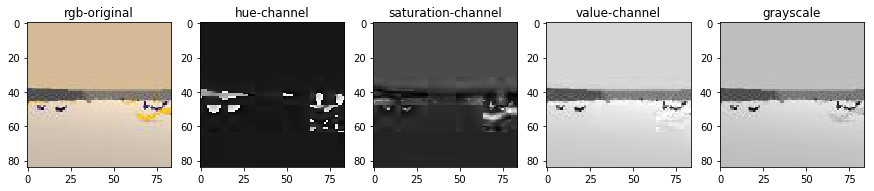

In [87]:
_state = _env.reset( training = False )
_hsvState = rgb_to_hsv( np.transpose( _state, (1,2,0) ) )

def rgb2gray(rgb):
    return 0.299 * rgb[0,...] + 0.587 * rgb[1,...] + 0.114 * rgb[2,...]

_grayState = rgb2gray(_state)
print( 'graystate.shape: ', _grayState.shape )
print( _grayState[2] )

plt.figure( figsize=(15,15) )
plt.subplot(151)
plt.imshow( np.transpose( _state, (1,2,0) ) )
plt.title( 'rgb-original' )

plt.subplot(152)
plt.imshow( _hsvState[...,0], cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'hue-channel' )

plt.subplot(153)
plt.imshow( _hsvState[...,1], cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'saturation-channel' )

plt.subplot(154)
plt.imshow( _hsvState[...,2], cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'value-channel' )

plt.subplot(155)
plt.imshow( _grayState, cmap = 'gray', vmin = 0., vmax = 1. )
plt.title( 'grayscale' )